# (08) DOVES—Categ—Lin—3

**Motivation**: New defaults fit + ```categorical```. Device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 3
device = f'cuda:{device_idx}'

model_type = 'categorical'

## Build model + trainer

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'lin|lin')
print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'DOVES', 'n_ch': 32, 'n_latents': 1, 'enc_type': 'lin', 'dec_type': 'lin', 'enc_bias': False, 
'dec_bias': False, 'n_categories': 512, 'init_dist': 'Normal', 'init_scale': 0.05}

Trainer:
{'temp_stop': 0.1, 'lr': 0.005, 'batch_size': 1000, 'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 
'grad_clip': 500, 'kl_const_portion': 0.0}

+----------------+------------+
|  Module Name   | Num Params |
+----------------+------------+
| CategoricalVAE |  262.1 K   |
|      ---       |    ---     |
|     fc_enc     |  131.1 K   |
|     fc_dec     |  131.1 K   |
+----------------+------------+

categorical-512_DOVES_z-1_<lin|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.1:lin-0.5)_gr(500)_(2024_05_08,19:32)

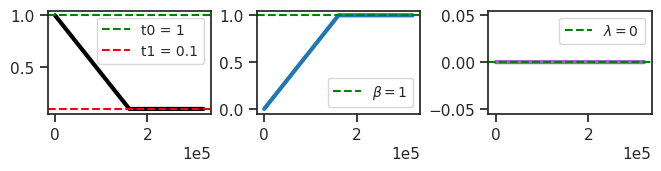

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [5]:
print(vae)

CategoricalVAE(
  (mse): MSELoss()
  (fc_enc): Linear(in_features=256, out_features=512, bias=False)
  (fc_dec): Linear(in_features=512, out_features=256, bias=False)
)

In [6]:
vae.fc_dec.bias, vae.fc_enc.bias #.shape

(None, None)

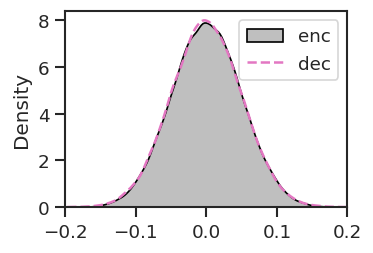

In [7]:
fig, ax= create_figure(dpi=120)
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.2, 0.2))
add_legend(ax)
plt.show()

### Train

In [8]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3000, avg loss: 172.071279: 100%|███████████████████████| 3000/3000 [51:30<00:00,  1.03s/it]


### Loss vld (freeze)

In [9]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 165.00491, 'kl': 5.4568934, 'kl_diag': 5.4385, 'tot': 170.4618}

### Identify dead neurons

In [21]:
c = dists.Categorical(torch.tensor(etc['logits'].mean(0)))

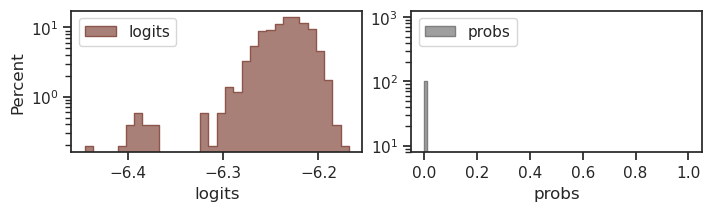

In [28]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(tonp(c.logits.ravel()), label='logits', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, 1, 101)
sns.histplot(tonp(c.probs.ravel()), ax=axes[1], bins=bins, label='probs', color='C7', **kws)

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[0].set(xlabel='logits', yscale='log')
axes[1].set(xlabel='probs', ylabel='', yscale='log')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

In [30]:
tonp(c.probs.ravel()).mean(), 1/ 512

(0.0019531252, 0.001953125)

### Plot dec weights

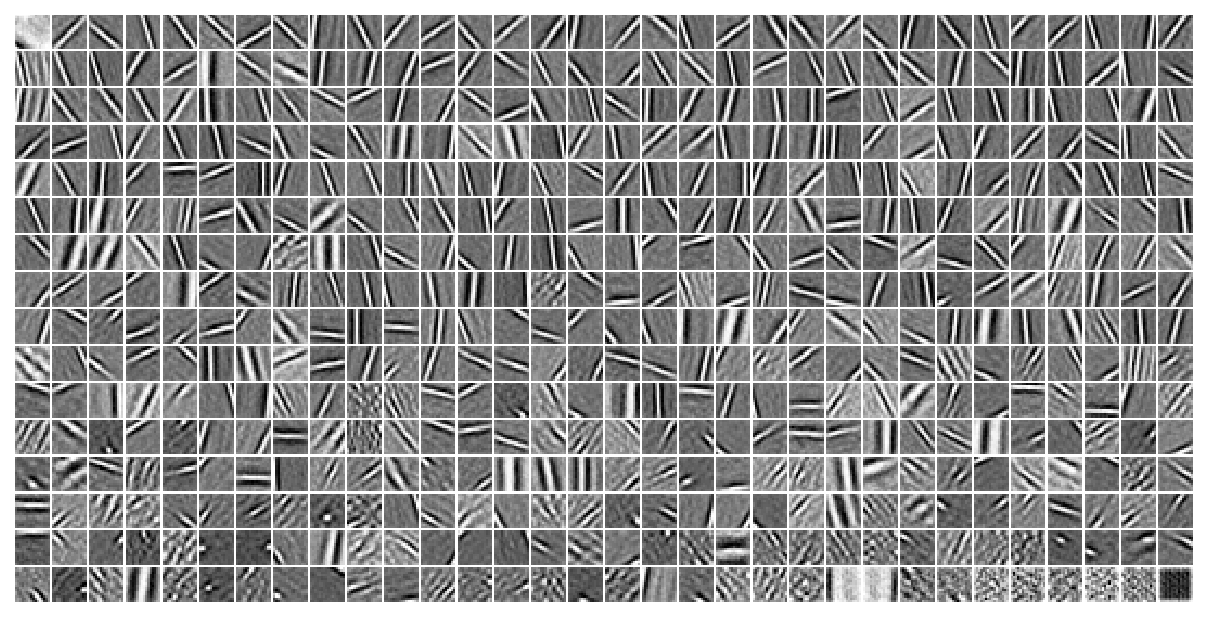

In [31]:
vae.show(dpi=150, order=np.argsort(etc['logits'].mean(0).ravel()));

## Loggabor

In [3]:
from analysis.loggabor import fit_loggabor
from figures.theta import plot_theta
from figures.imgs import plot_weights

### Load model

In [4]:
tr, meta = load_model(
    'categorical-512_DOVES_z-1_<lin|lin>',
    'mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.1:lin-0.5)_gr(500)_(2024_05_08,19:32)',
    device=device,
)
data, loss, etc = tr.validate()

In [5]:
dead = np.zeros(np.prod(tr.model.size)).astype(bool)
dead.sum()

0

### Fit loggabor

In [6]:
results = fit_loggabor(tr, verbose=True)

 65%|███████▏   | 335/512 [00:14<00:08, 21.89it/s]

 76%|████████▍  | 391/512 [00:16<00:05, 23.64it/s]

 84%|█████████▎ | 431/512 [00:17<00:03, 25.09it/s]

 88%|█████████▋ | 448/512 [00:18<00:02, 30.26it/s]

 91%|█████████▉ | 465/512 [00:18<00:01, 31.74it/s]

 92%|██████████▏| 473/512 [00:19<00:01, 30.77it/s]

 97%|██████████▋| 497/512 [00:19<00:00, 33.20it/s]

100%|███████████| 512/512 [00:20<00:00, 25.13it/s]


In [7]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,prior_probs
count,5.040000e+02,5.040000e+02,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,7.486014e+00,7.519299e+00,0.073976,0.216961,-0.166179,0.409262,0.191533,89.952820,0.001953
std,2.917766e+00,3.518845e+00,1.003751,0.042994,1.135610,0.153533,0.178039,43.517691,0.000000
min,2.511920e-10,4.066292e-08,-1.528629,0.092922,-5.739725,0.057948,0.068775,0.211196,0.001953
25%,5.915153e+00,4.746014e+00,-0.886990,0.195871,-0.620929,0.324289,0.115137,52.614426,0.001953
50%,7.490244e+00,7.596608e+00,0.250103,0.220612,-0.180182,0.402158,0.138814,89.694451,0.001953
75%,8.962092e+00,1.015663e+01,0.954813,0.242736,0.328695,0.461273,0.197682,126.113091,0.001953
max,1.600000e+01,1.537801e+01,1.570796,0.419626,5.166743,1.217038,2.470761,179.989256,0.001953


In [8]:
try:
    key = results.columns[-1] if tr.model.cfg.fit_prior else 'kl'
    rates_axial = results.loc[(results['label'] == 'axial') & ~dead, key].values
    rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, key].values
    print(f"{sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')}")
    a, b = len(rates_axial), len(rates_oblique)
    print(f"portions:   axial = {a/(a+b):0.2f} —— vs. —— oblique = {b/(a+b):0.2f}")
except KeyError:
    pass

In [9]:
from figures.theta import plot_theta

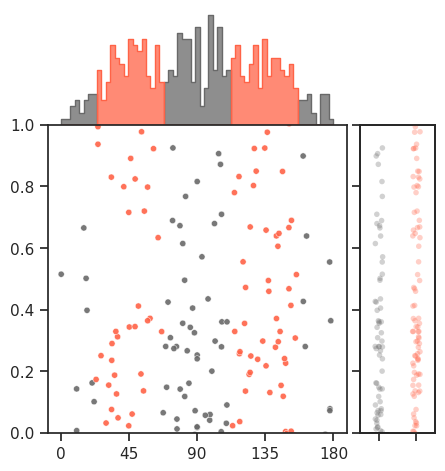

In [13]:
plot_theta(results, 'phase', ylim=None);

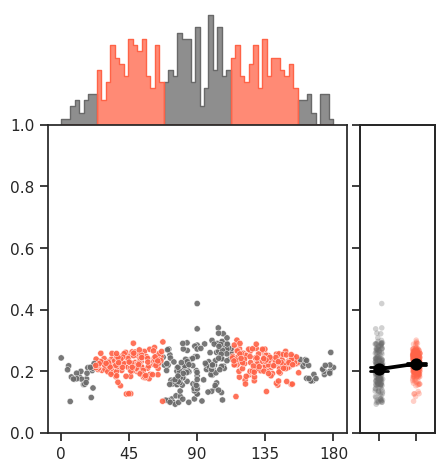

In [14]:
plot_theta(results, 'sf_0', ylim=None);

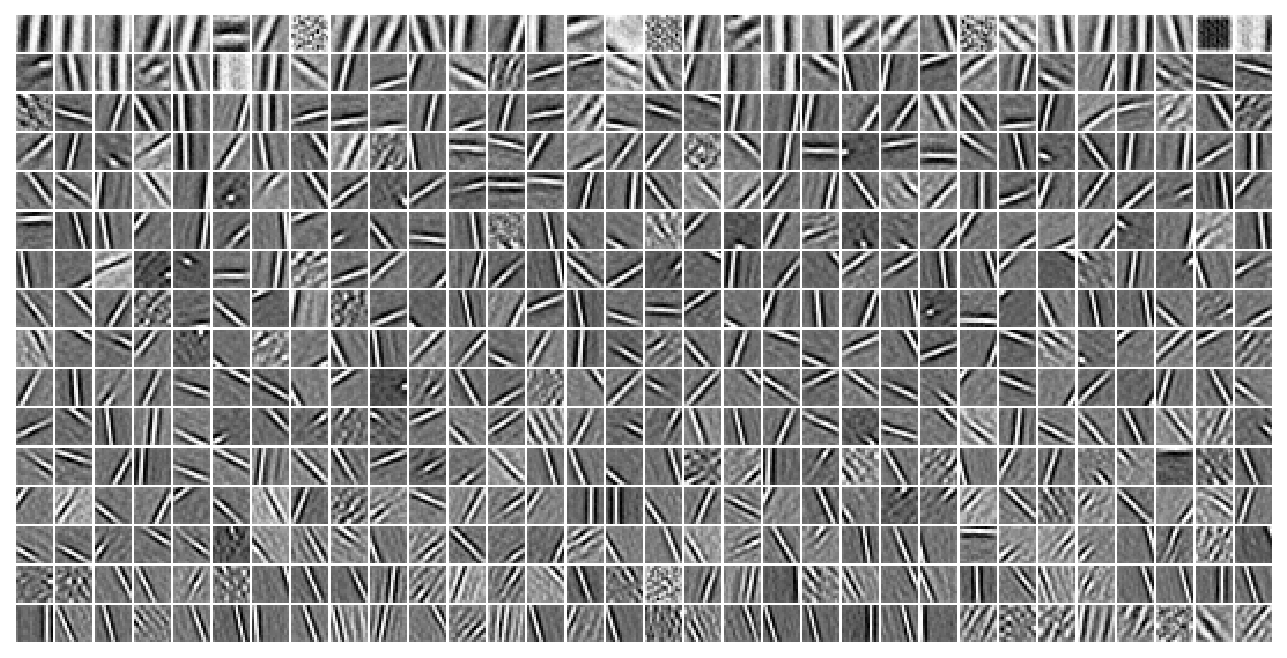

In [15]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show(order=order)

In [16]:
w_dec = tonp(tr.model.fc_dec.weight.data)
w_dec = w_dec.T.reshape(-1, 16, 16)
ids = np.argsort(results['sf_0'].values)

In [17]:
results['sf_0'][ids[:32]].values, results['sf_0'][ids[-32:]].values

(array([0.09292233, 0.098873  , 0.09915732, 0.09944309, 0.09952484,
        0.10176197, 0.10253016, 0.10323861, 0.10447427, 0.10605368,
        0.10663178, 0.10936825, 0.1097737 , 0.10998658, 0.11454649,
        0.1176101 , 0.11799543, 0.12011233, 0.12603281, 0.12604092,
        0.12604092, 0.12694095, 0.12708191, 0.13068053, 0.13226276,
        0.13405502, 0.13494669, 0.13559822, 0.13597731, 0.13858778,
        0.14273172, 0.14388688]),
 array([0.28469476, 0.28490445, 0.28719467, 0.28779447, 0.28803072,
        0.28807356, 0.28857563, 0.28967896, 0.29013328, 0.29015752,
        0.29020203, 0.29083712, 0.29208718, 0.29227545, 0.29507866,
        0.29673219, 0.30004628, 0.30083258, 0.30817551, 0.32166765,
        0.32339647, 0.33756112, 0.34060771, 0.41962634,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan]))

In [18]:
results['sf_0'][ids[-40:-8]].values

array([0.27418576, 0.274308  , 0.27498171, 0.2769864 , 0.27901393,
       0.28078077, 0.2815096 , 0.28222638, 0.28469476, 0.28490445,
       0.28719467, 0.28779447, 0.28803072, 0.28807356, 0.28857563,
       0.28967896, 0.29013328, 0.29015752, 0.29020203, 0.29083712,
       0.29208718, 0.29227545, 0.29507866, 0.29673219, 0.30004628,
       0.30083258, 0.30817551, 0.32166765, 0.32339647, 0.33756112,
       0.34060771, 0.41962634])

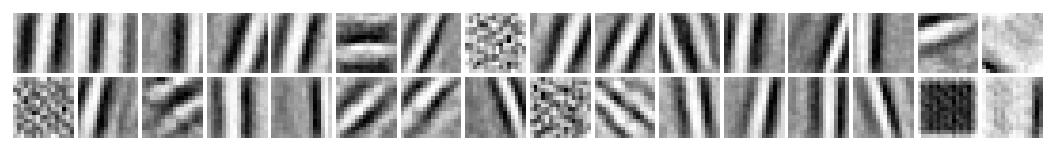

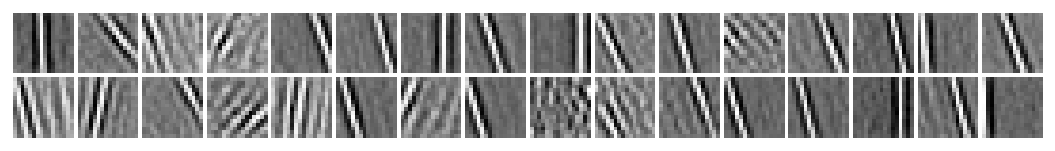

In [19]:
plot_weights(w_dec[ids[:32]], nrows=2, dpi=130)
plt.show()

plot_weights(w_dec[ids[-40:-8]], nrows=2, dpi=130)
plt.show()